When we run the current script, it takes some minutes to run the VWatt Script. The expected time should be less than 2 seconds since the program is only calculating curtailed generation in a day.

The reason behind this:

The original VWatt Script from Tim is written in a monthly basis
Tim's original script uses pd.read_csv for the data many times! (eg outside of the first and second run, in the first run, and in the second run), which is mainly the problem
So, possible solutions might be:

Modify the script into daily basis
Modify the script so that the pd.read_csv for the data is only deployed once.

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pytz #for timezone calculation
import math
import matplotlib.dates as md
import gc
import os
from datetime import datetime
%matplotlib qt
%matplotlib inline

# ================== Global parameters for fonts & sizes =================
font_size = 10
rc={'font.size': font_size, 'axes.labelsize': font_size, 'legend.fontsize': font_size, 
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')
 
# For label titles
fontdict={'fontsize': font_size, 'fontweight' : 'bold'}
# can add in above dictionary: 'verticalalignment': 'baseline' 

style = 'ggplot' # choose a style from the above options
plt.style.use(style)

def input_general_files(file_path):
    circuit_details = pd.read_csv(file_path + r"\unsw_20190701_circuit_details.csv")
    site_details = pd.read_csv (file_path + r"\unsw_20190701_site_details.csv")
    site_details = site_details.merge(circuit_details, left_on = 'site_id', right_on = 'site_id')
    unique_cids = pd.read_csv(file_path + r"\UniqueCids.csv", index_col = 0)
    return site_details, unique_cids

def site_organize(c_id_idx, site_details, data, unique_cids):
    """Get a single site data and relevant meta-data information.

    Args:
        c_id_idx (int): c_id value
        site_details (df): site_details dataframe from unsw_20190701_site_details.csv file
        data (df): D-PV time-series dataframe from input_monthly_file function output
        unique_cids (df): Dataframe listing unique c_id's and their corresponding site_id

    Returns:
        data_site(df): D-PV time-series dataframe, filtered by its site_id and cleaned (polarity correction etc)
        ac_cap (float): inverter capacity in W
        dc_cap (float): PV array capacity in Wp
        eff_system (float): Assumed PV array efficiency between 0 and 1
        inverter (str): Concatenated string of inverter manufacturer and model
        
    Originally written by Baran for VVAr Curtailment Calculation.
    """
    
    #c_id = unique_cids.loc[c_id_idx][0]
    c_id = c_id_idx
    
    polarity = site_details.loc[site_details['c_id'] == c_id, 'polarity'].values[0] # get the polarity of the site
    ac_cap = site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'].values[0]
    dc_cap = site_details.loc[site_details['c_id'] == c_id, 'dc_cap_w'].values[0]
    inverter = site_details.loc[site_details['c_id'] == c_id, 'inverter_manufacturer'].values[0] + ' ' + site_details.loc[site_details['c_id'] == c_id, 'inverter_model'].values[0]

    # Extract single site data and organize: 
    data_site = data[data['c_id'] == c_id].sort_index() # get the monthly data of the specific c_id

    data_site['power'] = data_site['power'].values * polarity # polarity correction for real power
    data_site.loc[data_site['power'] < 0, 'power'] = 0 #replace negative power value into zero
    data_site['reactive_power'] = data_site['reactive_power'].values * polarity # polarity correction for reactive power
    
    data_site['reactive_power'] = [data_site['reactive_power'].values * -1 if np.percentile(data_site.loc[(data_site.index.hour >= 7) & (data_site.index.hour <= 17), 'reactive_power'], 75) < 0 else data_site['reactive_power'].values][0]  # double check the polarity for reactive power
    
    if (abs(np.percentile(data_site['reactive_power'], 99))> ac_cap) | (abs(np.percentile(data_site['reactive_power'], 1))> ac_cap): #some VAr measurements in energy format and needs to be divided by duration (i.e., 60 sec)
        # data_site['reactive_power'] =  data_site['reactive_power'].values / data_site['duration'].values # unfortunately SolA data doesn't calculate energy according to respective duration but uses a fixed 60 sec values for energy calculation
        data_site['reactive_power'] =  data_site['reactive_power'].values / 60
        
    data_site.index = pd.to_datetime([str(d)[0:19] for d in data_site.index]) ## convert index to make the df plottable (by removing the UTC conversion)
    data_site.sort_index(ascending = True, inplace = True) # sort the index in ascending form
    # System efficiency for calculating theoretical max output later on (use conservative loss estimates for DC power)
    eff_inv = 0.98
    eff_vdrop = 0.98 
    eff_derating = 0.99  # module derating losses
    eff_system = eff_inv * eff_vdrop * eff_derating

    # Apparent power of the inverter
    data_site['va'] = np.sqrt (data_site['power'].values**2 + data_site['reactive_power'].values**2)
    data_site['pf'] = data_site['power']/data_site['va']
    
    return data_site, ac_cap, dc_cap, eff_system, inverter

def check_clear_sky_day(date):
    """Check whether a certain date is a clear sky day based on the ghi data of that day. Needs ghi data.

    Args:
    date (str): dat ein YYYYMMDD format

    Returns:
    clear_sky_day (bool): is it a clear sky day or not
    
    Funcitons needed:
    - Get_timestamp_date_string
    - Separate_ghi_data
    - Detect_clear_sky_day

    Originally written by Tim for VWatt Curtailment Calculation.
    """
    dateFile = date[:4]+'_'+ date[5:7]
    ghi = pd.read_csv(file_path +'/sl_023034_' + dateFile + ".txt")
    timestamp_date_string = Get_timestamp_date_string(dateFile)
    separated_ghi_data = Separate_ghi_data(timestamp_date_string, ghi)
    ghi_df = separated_ghi_data[date]
    res, average_delta_y = Detect_clear_sky_day(ghi_df, 530)

    if res:
        #clear_sky_days.append(date)
        #overall_clear_sky_days_dict[dateFile].append(date)
        is_clear_sky_day = True
    else:
        is_clear_sky_day = False
    return is_clear_sky_day

# ADJUST FORMATE FOR TIMESTAMP STRINGS
def Get_timestamp_date_string(string):
    x = string.split("_")
    return x[0] + "-" + x[1]

# LOOK FOR FOR SUDDEN VARIATIONS IN SOLAR INSOLATION DATA WHICH INDICATES LIKELY CLOUD COVER, AS OPPOSED TO CLEAR PARABOLIC SHAPE OF CLEAR SKY DAY GHI CURVES
def Detect_clear_sky_day(ghi_df, min_max_ghi):
    df_daytime = ghi_df.loc[ghi_df['mean_ghi'] > 0]

    collective_change = 0
    ghi_list = df_daytime.mean_ghi.tolist()

    for i in range(len(ghi_list)-1):
        collective_change += abs(ghi_list[i+1] - ghi_list[i])

    if len(df_daytime.index) == 0:
        return False, 0
    
    average_delta_y = collective_change/len(df_daytime.index)

    if average_delta_y < 5 and max(ghi_df.mean_ghi) > min_max_ghi:
        return True, average_delta_y
    else:
        return False, average_delta_y

# SEPARATE THE BoM GHI DATA FILES PER DAY TO SEARCH FOR CLEAR SKY DAYS
def Separate_ghi_data(month, ghi):
    ghi['ts'] = pd.to_datetime(pd.DataFrame({'year': ghi['Year Month Day Hours Minutes in YYYY'].values,
                                                    'month': ghi['MM'],
                                                    'day': ghi['DD'],
                                                    'hour': ghi['HH24'],
                                                    'minute': ghi['MI format in Local standard time']}))
    ghi.rename(columns={'Mean global irradiance (over 1 minute) in W/sq m': 'mean_ghi',
                        'Minimum 1 second global irradiance (over 1 minute) in W/sq m': 'min_ghi',
                        'Maximum 1 second global irradiance (over 1 minute) in W/sq m': 'max_ghi',
                        'Standard deviation of global irradiance (over 1 minute) in W/sq m': 'sd_ghi',
                        'Uncertainty in mean global irradiance (over 1 minute) in W/sq m': 'uncertainty_ghi'},
               inplace=True)
    key_ghi_values = ghi[['ts', 'mean_ghi', 'min_ghi', 'max_ghi', 'sd_ghi', 'uncertainty_ghi']].copy()
    key_ghi_values['mean_ghi'] = key_ghi_values.apply(lambda row: String_to_Float(row['mean_ghi']), axis=1)
    key_ghi_values['min_ghi'] = key_ghi_values.apply(lambda row: String_to_Float(row['min_ghi']), axis=1)
    key_ghi_values['max_ghi'] = key_ghi_values.apply(lambda row: String_to_Float(row['max_ghi']), axis=1)


    combined_ghi_dict = {}
    month_number = int(month.split('-')[1])

    for day in range(1, Days_in_month(month_number) + 1):
        day_string = str(day)
        if day < 10:
            day_string = "0" + day_string

        date = month + "-" + day_string
        df = key_ghi_values.loc[key_ghi_values['ts'] > date + " 00:00:01"]
        df = df.loc[key_ghi_values['ts'] < date + " 23:59:01"]

        combined_ghi_dict[date] = df

    return combined_ghi_dict

# REMOVE SPACES AND CHECK IF VALUE NULL
def String_to_Float(string):
    x = string.strip()
    if not x:
        x = 0
    else:
        x = float(x)
    return x

def Days_in_month(month):
        switcher = {
            1: 31,
            2: 29,
            3: 31,
            4: 30,
            5: 31,
            6: 30,
            7: 31,
            8: 31,
            9: 30,
            10: 31,
            11: 30,
            12: 31,
        }
        return switcher.get(month, 0)

file_path = r"C:\Users\samha\Documents\CANVAS\data"
site_details, unique_cids= input_general_files(file_path)
sample_filename = '/data_sample_3.csv'

data = pd.read_csv(file_path + sample_filename)
pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
data['Timestamp'] = pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
data.set_index('Timestamp', inplace=True)

c_id = data['c_id'][0]
date = str(data.index[0])[:10]

In [92]:
data_site, ac_cap, dc_cap, eff_system, inverter = site_organize(c_id, site_details, data, unique_cids)
data_site['cf'] = data_site['power']/ac_cap

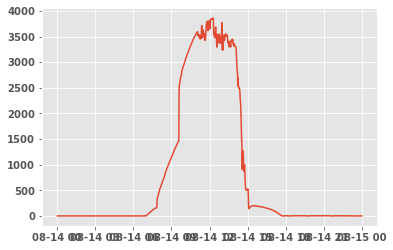

In [94]:
plt.plot(data_site['power'])

In [ ]:
if data_site is None:
    #return 'n/a', 'n/a'

if len(data_site.index) == 0:
    #return 'n/a', 'n/a'

if max(data_site.cf) < 0.3:
    #return 'n/a', 'n/a'

is_clear_sky_day = check_clear_sky_day(date) 
#this contains redundant steps like making ghi dict for all days etc, can still be improved.

if not is_clear_sky_day:
    vwatt_response = 'Inconclusive due to non clear sky day.'
    vwatt_curt_energy = float('nan')
    #return vwatt_response, vwatt_curt_energy

#2. put algorithm to do polyfit and check polyfit quality here

if not good_polyfit_quality:
    vwatt_response = 'Inconclusive due to poor power data'
    vwatt_curt_energy = float('nan')
    #return vwatt_response, vwatt_curt_energy

#3. put algorithm to check overvoltage sufficiency here

elif not overvoltage_sufficient:
    vwatt_response = 'Inconclusive due to insufficient overvoltage datapoint.'
    vwatt_curt_energy = float('nan')
    #return vwatt_response, vwatt_curt_energy
    
#4. put algorithm to check vwatt-response here
#vwatt_response = ...

elif vwatt_response == 'No':
    vwatt_curt_energy = 0
    #return vwatt_response, vwatt_curt_energy
    
else: #there is vwatt_response detected
    #5. calculate vwatt curt energy here
    #return vwatt_response, vwatt_curt_energy

In [100]:
data_site

c_id  energy       power  reactive_power  voltage  \
2019-08-14 07:52:55  466930914   20076  334.600000      -91.000000    243.5   
2019-08-14 07:53:55  466930914   21317  355.283333      -74.766667    244.9   
2019-08-14 07:54:55  466930914   21885  364.750000      -86.550000    244.7   
2019-08-14 07:55:55  466930914   22943  382.383333      -88.000000    244.4   
2019-08-14 07:56:55  466930914   23494  391.566667      -86.266667    243.8   
...                        ...     ...         ...             ...      ...   
2019-08-14 14:59:55  466930914   31341  522.350000      -93.466667    249.6   
2019-08-14 15:00:55  466930914   31262  521.033333      -96.633333    249.7   
2019-08-14 15:01:55  466930914   31521  525.350000      -73.133333    249.4   
2019-08-14 15:02:55  466930914   28606  476.766667      -63.516667    249.4   
2019-08-14 15:03:55  466930914   19579  326.316667      -57.383333    249.5   

                     duration          va        pf        cf  
2019-08-14 07:52:55        60  346.753745  0.964950  0.066920  
2019-08-14 07:53:55        60  363.065148  0.978566  0.071057  
2019-08-14 07:54:55        60  374.877933  0.972983  0.072950  
2019-08-14 07:55:55        60  392.378661  0.974526  0.076477  
2019-08-14 07:56:55        60  400.956846  0.976581  0.078313  
...                       ...         ...       ...       ...  
2019-08-14 14:59:55        60  530.646342  0.984366  0.104470  
2019-08-14 15:00:55        60  529.918612  0.983233  0.104207  
2019-08-14 15:01:55        60  530.415975  0.990449  0.105070  
2019-08-14 15:02:55        60  480.979024  0.991242  0.095353  
2019-08-14 15:03:55        60  331.323730  0.984888  0.065263  

[431 rows x 9 columns]

In [22]:
test = data_site[data_site['voltage']>250]

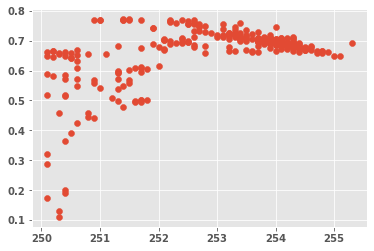

In [24]:
plt.scatter(test['voltage'], test['cf'])

In [101]:
data_site.index.rename('ts', inplace = True)

In [96]:
sunrise, sunset, data_site = filter_sunrise_sunset(data_site)
data_site = data_site.loc[data_site['power'] > 300]

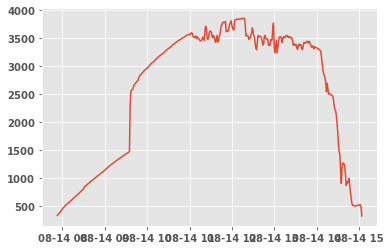

In [97]:
plt.plot(data_site['power'])

In [ ]:
# ORGANISE DATA FOR DETERMINING COMPLIANCE FUNCTION BELOW
def Append_Volt_Watt_behaviour_data(df, c_id, date, dc_cap_w):    

    if df is None:
        return None, None, None, None

    if len(df.index) == 0:
        return None, None, None, None
    
    if max(df.power) < 0.3:
        return None, None, None, None

    df = SliceEndOffDF(df)

    df = df.loc[df['power'] > 300]

    if len(df.index) < 20:
        return None, None, None, None

    # Filter power data for only 'uncurtailed instances' (estimation as it is unknown when inverter is actively curtailing output)
    powerArray, timeArray = FilterPowerData(df)

    # Filter data for limited gradients, useful in creating more accurate polyfits, as determined by visual verification
    powerArray, timeArray = FilterDataLimitedGradients(powerArray, timeArray)

    if powerArray is None or len(powerArray) < 20:
        return None, None, None, None

    # Get polyfit estimation
    polyfit = GetPolyfit(getDateTimeList(timeArray), powerArray, 2)

    # Simple filter for very high and low values to aid in displaying data in figures
    filteredPowerArray, filteredTimeArray = FilterArray(polyfit(getDateTime(df)), getDateTime(df), 100000, 0)
    
    filteredPowerArray = Change_W_to_kW(filteredPowerArray)
    
    maxPower = max(filteredPowerArray)
    

    maxCompliance = 0
    bestVWLimit = 248
    bestTotalPoints = 1

    # Determine which data points are of interest for compliance by comparing actual output vs polyfit predicted output, and voltage conditions
    # Ie. W-Watt curtailment can only occur when P_modelled > P_max_allowed.
    complianceCount, voltArrayCompliance, timeArrayCompliance, absoluteWattArrayCompliance, relativeWattArrayCompliance, successfulRelativeWattArray, successfulVoltArray = DetermineCompliance(
        polyfit, df, dc_cap_w, 248)
    maxVoltWattTimeArray, maxVoltWattPowerArray = getMaxVoltWattCurve(dc_cap_w, df, 249)


    if len(voltArrayCompliance) > 0:
        return voltArrayCompliance, relativeWattArrayCompliance, filteredTimeArray, filteredPowerArray

    return None, None, None, None

In [82]:
def filter_sunrise_sunset(df):
    """Filter a D-PV Time series data based on its estimated sunrise and sunset time.

    Args:
    df (df): D-PV Time series data

    Returns:
    sunrise (timestamp): estimated sunrise time (when power is >10 W for the first time in a day)
    sunset (timestamp): the opened ghi data (when power is >10 W for the last time in a day)
    df (df): filtered D-PV Time series data
    """
    if df is None or len(df.index) == 0:
        return None

    tmpDF = df.loc[df['power'] > 10]
    if len(tmpDF.index) == 0:
        return None

    sunrise = tmpDF.index[0]
    sunset = tmpDF.index[-1]

    df = df.loc[df.index > sunrise]
    df = df.loc[df.index < sunset]

    return sunrise, sunset, df

In [114]:
def filter_power_data(df):
    """Take the time and power data from D-PV time-series data & filter out curtailment. Will be used for polyfit regression.

    Args:
    df (df): Time-series D-PV data with power column and timestamp as an index

    Returns:
    powerArray (pd series): filtered power data
    timeArray (pd datetime): filtered timestamp data
    """
    
    maxDailyPower = max(df.power)
    if len(df.loc[df['power'] == maxDailyPower].index) > 1:
        return None, None
    
    filter_first_half = []
    filter_second_half = []
    powerArray = df.power
    timeArray = df.index
    
    halfFlag = True  # True is first half, False is second half
    last_highest_power = 0
    
    for power in powerArray:

        # IF power IS GREATER THAN last_highest_power THEN INCLUDE power AND INCREASE last_highest_power
        if power > last_highest_power:
            last_highest_power = power
            filter_first_half.append(True)
        else:
            filter_first_half.append(False)

        if power == maxDailyPower:
            break
            
    last_highest_power = 0
    
    # PERFORM SAME FILTER ON SECOND SIDE OF POWER ARRAY
    for power in powerArray.iloc[::-1]:

        if power == maxDailyPower:
            break

        if power > last_highest_power:
            last_highest_power = power
            filter_second_half.append(True)
        else:
            filter_second_half.append(False)
            
    # COMBINE TO FILTERED SIDES
    filter_second_half.reverse()
    filterArray = filter_first_half + filter_second_half
    return powerArray[filterArray], timeArray[filterArray]

In [174]:
powerArray, timeArray = filter_power_data(data_site)

In [171]:
def FilterDataLimitedGradients(powerArray, timeArray):
    """Filter the powerArray data so it includes only decreasing gradient (so the shape is parabolic)

    Args:
    powerArray (pd series): non curtailment filtered power data
    timeArray (pd datetime): non curtailment filtered timestamp data

    Returns:
    powerArray (pd series): gradient filtered power data
    timeArray (pd datetime): gradient filtered timestamp data
    
    Written by Tim
    """

    if powerArray is None:
        return None, None

    # IN GENERAL ANLGE MUST BE BETWEEN THESE VALUES
    angleLowerLimit = 80
    angleUpperLimit = 90

    # BUT AFTER 'continuanceLimit' CONTINUOUS VALUES HAVE BEEN ACCEPTED, THE LOWER ANGLE LIMIT IS RELAXED TO THIS VALUE BELOW
    widerAngleLowerLimit = 70
    continuanceLimit = 2

    gradients = []
    timeGradients = []
    powerArray = powerArray.tolist()
    timeArray = timeArray.tolist()
    filterArray = []

    n = len(powerArray)
    gradientsCompliance = [0] * n

    runningCount = 0

    for i in range(1, n):
        g = abs(math.degrees(math.atan((powerArray[i] - powerArray[i - 1]) / (
                    getSingleDateTime(timeArray[i]) - getSingleDateTime(timeArray[i - 1])))))

        addFlag = False

        if g > angleLowerLimit and g < angleUpperLimit:
            addFlag = True
            runningCount += 1

        elif runningCount > continuanceLimit and g > widerAngleLowerLimit:
            addFlag = True

        else:
            runningCount = 0

        if addFlag:
            gradientsCompliance[i - 1] += 1
            gradientsCompliance[i] += 1

        if g > 85:
            gradients.append(g)
            timeGradients.append(timeArray[i])

    if gradientsCompliance[0] == 1 and gradientsCompliance[1] == 2:
        filterArray.append(True)
    else:
        filterArray.append(False)

    for i in range(1, n - 1):
        if gradientsCompliance[i] == 2:
            filterArray.append(True)
        elif gradientsCompliance[i] == 1 and (gradientsCompliance[i - 1] == 2 or gradientsCompliance[i + 1] == 2):
            filterArray.append(True)
        else:
            filterArray.append(False)

    if gradientsCompliance[n - 1] == 1 and gradientsCompliance[n - 2] == 2:
        filterArray.append(True)
    else:
        filterArray.append(False)
    

    powerArray = pd.Series(powerArray)
    timeArray = pd.Series(timeArray)

    powerArray = powerArray[filterArray]
    timeArray = timeArray[filterArray]

    return powerArray, timeArray

def getSingleDateTime(d):
    """CONVERT A SINGLE STRING TIMESTAMP TO DATETIME OBJECTS

    Args:
    d (str): string timestamp

    Returns:
    daetimeobject
    
    Written by Tim
    """
    return md.date2num(datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))

In [175]:
timeArray = timeArray.strftime('%Y-%m-%d %H:%M:%S')
timeArray = timeArray.to_series(index=None, name='None')
powerArray, timeArray = FilterDataLimitedGradients(powerArray, timeArray)